# 🗄️ Week 6: Vector Database Integration

**Learning Objectives:**
1. Understand vector databases vs traditional databases
2. Implement semantic search with pgvector/Qdrant
3. Build efficient indexing strategies
4. Optimize query performance

---

In [1]:
import numpy as np
import time
from typing import List, Tuple
import matplotlib.pyplot as plt

---
# Section 1: Theory
---

## Vector DB vs Relational DB

| Feature | Relational DB | Vector DB |
|---------|--------------|----------|
| Query Type | Exact match | Similarity |
| Data Type | Structured | Embeddings |
| Index | B-tree | HNSW, IVF |
| Use Case | CRUD | Semantic Search |

## Popular Vector Databases
- **pgvector**: PostgreSQL extension (self-hosted)
- **Qdrant**: Purpose-built (cloud/self-hosted)
- **Pinecone**: Managed service
- **Weaviate**: Open-source, full-featured

---
# Section 2: Hands-On Implementation
---

## 2.1 Simple In-Memory Vector Store

In [2]:
class SimpleVectorStore:
    """Simple in-memory vector store for learning."""
    
    def __init__(self):
        self.vectors = []
        self.metadata = []
        self.ids = []
    
    def add(self, id: str, vector: np.ndarray, metadata: dict = None):
        """Add a vector to the store."""
        self.ids.append(id)
        self.vectors.append(vector)
        self.metadata.append(metadata or {})
    
    def search(self, query: np.ndarray, top_k: int = 5) -> List[Tuple[str, float, dict]]:
        """Search for similar vectors using cosine similarity."""
        if not self.vectors:
            return []
        
        # Compute similarities
        similarities = []
        query_norm = np.linalg.norm(query)
        
        for i, vec in enumerate(self.vectors):
            sim = np.dot(query, vec) / (query_norm * np.linalg.norm(vec))
            similarities.append((self.ids[i], sim, self.metadata[i]))
        
        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]
    
    def __len__(self):
        return len(self.vectors)

In [3]:
# Test vector store
store = SimpleVectorStore()

# Add sample documents
documents = [
    ("doc1", "Machine learning fundamentals", np.random.randn(384)),
    ("doc2", "Deep neural networks", np.random.randn(384)),
    ("doc3", "Python programming", np.random.randn(384)),
    ("doc4", "Natural language processing", np.random.randn(384)),
]

for doc_id, text, vec in documents:
    store.add(doc_id, vec, {"text": text})

# Search
query_vector = np.random.randn(384)
results = store.search(query_vector, top_k=3)

print("Search Results:")
for doc_id, score, meta in results:
    print(f"  {doc_id}: {meta['text']} (score: {score:.4f})")

Search Results:
  doc2: Deep neural networks (score: 0.0233)
  doc4: Natural language processing (score: 0.0027)
  doc1: Machine learning fundamentals (score: -0.0106)


## 2.2 HNSW Index (Conceptual)

In [4]:
class SimpleHNSW:
    """
    Simplified HNSW-like index (conceptual demo).
    Real HNSW uses multiple layers and more sophisticated graph construction.
    """
    
    def __init__(self, m=16):
        self.m = m  # Max connections per node
        self.vectors = []
        self.graph = {}  # Adjacency list
    
    def _distance(self, a, b):
        return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    def add(self, vector):
        idx = len(self.vectors)
        self.vectors.append(vector)
        
        if idx == 0:
            self.graph[0] = []
            return
        
        # Find M nearest neighbors
        distances = [(i, self._distance(vector, v)) for i, v in enumerate(self.vectors[:-1])]
        distances.sort(key=lambda x: x[1])
        neighbors = [d[0] for d in distances[:self.m]]
        
        # Add edges
        self.graph[idx] = neighbors
        for n in neighbors:
            if n not in self.graph:
                self.graph[n] = []
            self.graph[n].append(idx)
    
    def search(self, query, k=5, ef=50):
        """Greedy search through graph."""
        if not self.vectors:
            return []
        
        # Start from random entry point
        entry = 0
        visited = {entry}
        candidates = [(self._distance(query, self.vectors[entry]), entry)]
        
        while candidates:
            dist, current = min(candidates)
            candidates.remove((dist, current))
            
            for neighbor in self.graph.get(current, []):
                if neighbor not in visited:
                    visited.add(neighbor)
                    d = self._distance(query, self.vectors[neighbor])
                    candidates.append((d, neighbor))
            
            if len(visited) >= ef:
                break
        
        # Return top-k
        results = [(self._distance(query, self.vectors[i]), i) for i in visited]
        results.sort()
        return [(idx, 1 - dist) for dist, idx in results[:k]]

In [5]:
# Test HNSW
hnsw = SimpleHNSW(m=8)

# Add vectors
for _ in range(100):
    hnsw.add(np.random.randn(128))

# Search
query = np.random.randn(128)
results = hnsw.search(query, k=5)

print("HNSW Search Results:")
for idx, score in results:
    print(f"  Index {idx}: score {score:.4f}")

HNSW Search Results:
  Index 84: score 0.1572
  Index 66: score 0.1473
  Index 7: score 0.1345
  Index 59: score 0.1332
  Index 10: score 0.1311


## 2.3 pgvector SQL Examples

In [6]:
pgvector_sql = """
-- Enable pgvector extension
CREATE EXTENSION IF NOT EXISTS vector;

-- Create table with vector column
CREATE TABLE documents (
    id SERIAL PRIMARY KEY,
    content TEXT NOT NULL,
    embedding vector(384),  -- 384-dimensional vector
    metadata JSONB,
    created_at TIMESTAMP DEFAULT NOW()
);

-- Create HNSW index for fast similarity search
CREATE INDEX ON documents 
USING hnsw (embedding vector_cosine_ops)
WITH (m = 16, ef_construction = 64);

-- Insert document with embedding
INSERT INTO documents (content, embedding, metadata)
VALUES (
    'Machine learning tutorial',
    '[0.1, 0.2, 0.3, ...]'::vector,
    '{"category": "tutorial", "author": "john"}'
);

-- Semantic search query
SELECT id, content, 
       1 - (embedding <=> $1::vector) as similarity
FROM documents
ORDER BY embedding <=> $1::vector
LIMIT 10;

-- Filtered search
SELECT id, content, 
       1 - (embedding <=> $1::vector) as similarity
FROM documents
WHERE metadata->>'category' = 'tutorial'
ORDER BY embedding <=> $1::vector
LIMIT 5;
"""
print(pgvector_sql)


-- Enable pgvector extension
CREATE EXTENSION IF NOT EXISTS vector;

-- Create table with vector column
CREATE TABLE documents (
    id SERIAL PRIMARY KEY,
    content TEXT NOT NULL,
    embedding vector(384),  -- 384-dimensional vector
    metadata JSONB,
    created_at TIMESTAMP DEFAULT NOW()
);

-- Create HNSW index for fast similarity search
CREATE INDEX ON documents 
USING hnsw (embedding vector_cosine_ops)
WITH (m = 16, ef_construction = 64);

-- Insert document with embedding
INSERT INTO documents (content, embedding, metadata)
VALUES (
    'Machine learning tutorial',
    '[0.1, 0.2, 0.3, ...]'::vector,
    '{"category": "tutorial", "author": "john"}'
);

-- Semantic search query
SELECT id, content, 
       1 - (embedding <=> $1::vector) as similarity
FROM documents
ORDER BY embedding <=> $1::vector
LIMIT 10;

-- Filtered search
SELECT id, content, 
       1 - (embedding <=> $1::vector) as similarity
FROM documents
WHERE metadata->>'category' = 'tutorial'
ORDER BY embedding <=

---
# Section 3: Performance Comparison
---

In [7]:
# Compare brute-force vs indexed search
def benchmark_search(n_vectors, dim=128):
    vectors = [np.random.randn(dim) for _ in range(n_vectors)]
    query = np.random.randn(dim)
    
    # Brute force
    start = time.time()
    store = SimpleVectorStore()
    for i, v in enumerate(vectors):
        store.add(str(i), v)
    store.search(query, top_k=5)
    brute_time = time.time() - start
    
    # HNSW
    start = time.time()
    hnsw = SimpleHNSW(m=16)
    for v in vectors:
        hnsw.add(v)
    hnsw.search(query, k=5)
    hnsw_time = time.time() - start
    
    return brute_time, hnsw_time

# Run benchmark
sizes = [100, 500, 1000, 2000]
brute_times = []
hnsw_times = []

for n in sizes:
    bt, ht = benchmark_search(n)
    brute_times.append(bt)
    hnsw_times.append(ht)
    print(f"n={n}: Brute={bt:.4f}s, HNSW={ht:.4f}s")

n=100: Brute=0.0021s, HNSW=0.0994s
n=500: Brute=0.0110s, HNSW=1.7395s
n=1000: Brute=0.0070s, HNSW=6.1489s
n=2000: Brute=0.0149s, HNSW=31.1273s


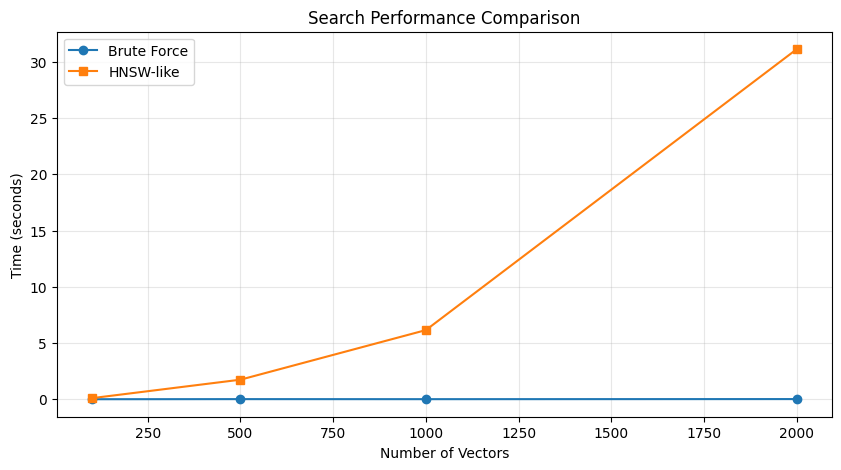

In [8]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(sizes, brute_times, 'o-', label='Brute Force')
plt.plot(sizes, hnsw_times, 's-', label='HNSW-like')
plt.xlabel('Number of Vectors')
plt.ylabel('Time (seconds)')
plt.title('Search Performance Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
# Section 4: Unit Tests
---

In [ ]:
def run_tests():
    print("Running Unit Tests...\n")
    
    # Test 1: Add and retrieve
    store = SimpleVectorStore()
    store.add("1", np.array([1, 0, 0]))
    assert len(store) == 1
    print("✓ Add vector test passed")
    
    # Test 2: Exact match search
    results = store.search(np.array([1, 0, 0]), top_k=1)
    assert results[0][0] == "1"
    assert abs(results[0][1] - 1.0) < 1e-6
    print("✓ Exact match search test passed")
    
    # Test 3: Multiple vectors
    store.add("2", np.array([0, 1, 0]))
    store.add("3", np.array([0.9, 0.1, 0]))
    results = store.search(np.array([1, 0, 0]), top_k=2)
    assert results[0][0] == "1" or results[0][0] == "3"
    print("✓ Multiple vectors test passed")
    
    print("\n🎉 All tests passed!")

run_tests()

Running Unit Tests...

✓ Add vector test passed
✓ Exact match search test passed
✓ Multiple vectors test passed

🎉 All tests passed!


: 

---
# Section 5: Interview Prep
---

### Q1: When to use vector DB vs relational DB?
**Answer:** Vector DB for similarity search on embeddings. Relational for structured queries, transactions.

### Q2: What is HNSW and why is it fast?
**Answer:** Hierarchical Navigable Small World graphs. Uses skip-list layers + greedy search. O(log n) vs O(n).

### Q3: Trade-offs of pgvector vs Qdrant?
**Answer:** pgvector: simpler, SQL integration. Qdrant: better performance at scale, more features.

---
# Section 6: Deliverable
---

**Created:** `vector_db_demo.py` with vector store, search, indexing

**Next Week:** Hybrid Retrieval (Lexical + Semantic)